# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="../prioritized_ddqn/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]

BananaBrain


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4.Double Deep Dueling Q Noisy Network Agent with Prioritized Experience Replay

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import os
import sys
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [6]:
print(os.listdir('../'))
sys.path.append('../')

%reload_ext autoreload
%autoreload 2

from replay_memory import *

['.git', '.gitignore', '.ipynb_checkpoints', 'noisy_net', 'prioritized_ddqn', 'prioritized_dueling_ddqn', 'README.ipynb', 'README.md', 'replay_memory.py', 'Report.ipynb', '__pycache__']


In [7]:
# Factorised NoisyLinear layer with bias
class NoisyLinear(nn.Module):
    
    '''
        Adapted from https://github.com/Kaixhin/Rainbow/blob/master/model.py
    '''
    def __init__(self, in_features, out_features, std_init=0.01):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.zeros(out_features, in_features))
        # This is typically used to register a buffer that should not to be considered a model parameter
        self.register_buffer('weight_epsilon', torch.zeros(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_sigma = nn.Parameter(torch.zeros(out_features))
        self.register_buffer('bias_epsilon', torch.zeros(out_features))
        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        mu_range = self.std_init / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.normal_(0.0, self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.normal_(0.0, self.std_init / np.sqrt(self.in_features))

    def _scale_noise(self, size):
        x = torch.FloatTensor(size).normal_(0, self.std_init)
        return x.sign().mul_(x.abs().sqrt_())

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in)) # ger is outer product
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x):
        if self.training:
            return F.linear(x, self.weight_mu + self.weight_sigma * self.weight_epsilon, self.bias_mu + self.bias_sigma * self.bias_epsilon)
        else:
            return F.linear(x, self.weight_mu, self.bias_mu)


In [8]:
class QNetwork(nn.Module):
    '''
        Deep neural network for approximation of q-values
    '''
    
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64, fc1_adv_units=32, fc1_val_units=16, 
                 noise_std=0.1):
        '''
            Parameters
            ----------
            state_size (int) : size of each state (37)
            action_size (int) : dimension of action space (number of possible actions in each state)
            fc1_units (int): output channels of the 1st fully connected layer
            fc2_units (int): output channels of the 2nd fully connected layer
            fc3_units (int): output channels of the 3rd fully connected layer
        '''
        
        super(QNetwork, self).__init__()
        torch.manual_seed(seed)
        self.action_size = action_size
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        
        self.fc1_adv = nn.Linear(fc2_units, fc1_adv_units) 
        self.fc2_adv = NoisyLinear(fc1_adv_units, self.action_size, noise_std) 
        
        self.fc1_val = nn.Linear(fc2_units, fc1_val_units)
        self.fc2_val = NoisyLinear(fc1_val_units, 1, noise_std)
        
    def forward(self, x):
        
        batch_size = x.size()[0]
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        adv = F.relu(self.fc1_adv(x))
        adv = self.fc2_adv(adv)  # [batch_size, action_size]
        mean_adv = adv.mean(dim=1, keepdim=True).expand(batch_size, self.action_size)
        
        val = F.relu(self.fc1_val(x))
        val = self.fc2_val(val).expand(batch_size, self.action_size)
        
        return val + (adv - mean_adv) 


In [10]:
class Agent():

    def __init__(self, device, state_size, action_size, seed, buffer_size=int(1e5),priority_eps=1e-3,
                 replay_alpha= 0.7, batch_size=64, gamma=0.99, update_every=4, tau=1e-3, 
                 lr=5e-4,optim_step_size=500, optim_gamma=0.8, is_train=True, net_noise=0.1):
        
        '''
            Parameters
            ----------
            device (string): pytorch-based computation device: cpu or cuda 
            state_size (int) : size of each state (37)
            action_size (int) : dimension of action space (number of possible actions in each state)
            seed (int): initialization value for random generators
            buffer_size (int): sample size to be stored
            priority_eps (float): a minimum value of priorities (small value added to priorities) 
            replay_alpha (flaot): determine the degree of priorization used in sampling the buffer: 
                0 for uniform random, 
                1 for pure priority based selection
                Prob_i \sim priority_i**alpha/sum(priority**alpha)
            batch_size (int): batch size of experiences used to train the agent
            gamma (float): a reward discount rate
            update_every (int): period to which a target q-network gets updated from a behavior q-network 
            tau (float): weights for weighted average of the parameter values of the target q-network and the behavior network 
            lr (float): agent learning rate
            optim_step_size (int): number of step at which the learning rate gets updated
            optim_gamma (float): factor to which learning rate is adjusted
            is_train (bool): whether the agent is in training mode
        '''
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        self.device = device
        self.action_size = action_size
        self.is_train = is_train
        
        self.behavior_qnet = QNetwork(state_size, action_size, seed).to(self.device)
        self.target_qnet = QNetwork(state_size, action_size, seed).to(self.device)
        self.memory = ReplayMemory(buffer_size, batch_size, replay_alpha, seed, self.device)
        
        self.priority_eps = priority_eps
        self.lr = lr
        self.grad_abs_max = []
        self.grad_abs_min = []
        self.optimizer = optim.Adam(self.behavior_qnet.parameters(), self.lr)
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=optim_step_size, gamma=optim_gamma)
        
        self.batch_size = batch_size
        self.gamma = gamma # discount rate
        self.update_every = update_every
        self.tau = tau
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done, beta):
        """
        Add a new experience to the replay memory and train the agent.
        
        Parameters
        ----------
        state (37-element float list): current state of environment (at time t)
        action (int): action applied at time t
        reward (float): reward returned by the environment at time t+1
        next_state (37-element float list): next state of environment (at time t+1)
        done (bool): whether the episode ends
        priority (float): priority of this experience (state, action, reward, next_state, done)
        beta (float) : strength of correction (annealing) for non-uniform sampling, default 0.5
                       value should gradually increase to 1. at the end of learning (the q-value converges)
        """
        # save experience
        if isinstance(reward, complex): raise ValueError('Reward is complex ', reward)
        self.memory.add(state, action, reward, next_state, done, (np.abs(reward)+self.priority_eps) )
        
        # learn every update_every step
        self.t_step = (self.t_step+1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.select(beta)
                self.learn(experiences)
                
    def learn(self, experiences):
        
        """
        Learn from experiences
        
        Parameters
        ----------
        experiences (tuple): containing 
            states (floating tensor): torch tensor of size [batch_size, 37]
            actions (long tensor): torch tensor of size [batch_size, 1]
            rewards (floating tensor): : torch tensor of size [batch_size, 1]
            next_states (floating tensor): torch tensor of size [batch_size, 37]
            dones (floating tensor): : torch tensor of size [batch_size, 1]
            weights (floating tensor): : torch tensor of size [batch_size, 1] for important sampling weights
            indices (list): indices of sample sampled from the replay memory (i.e., sample positions in a sum tree)
        """
        
        # decompose experiences
        states, actions, rewards, next_states, dones, weights, indices = experiences
        
        # prepare gradient calculation
        self.optimizer.zero_grad()
        self.behavior_qnet.zero_grad()
        
        priorities = [None]*self.batch_size
        for isx, state in enumerate(states):
            
            # get current estimate of q values
            q_estimate = self.behavior_qnet(state.unsqueeze(0))[0,actions[isx]]
            
            # get target q values
            with torch.no_grad():
                max_q_index = self.behavior_qnet(next_states[isx].unsqueeze(0)).argmax().unsqueeze(0)
                q_target_next = self.target_qnet(next_states[isx].unsqueeze(0))[0, max_q_index]
                q_target = rewards[isx] + (self.gamma * q_target_next * (1.-dones[isx]))

            # compute differences
            loss = F.smooth_l1_loss(q_estimate, q_target.detach())
            td_err = torch.abs(q_estimate.detach() - q_target.detach()) + self.priority_eps
            
             # update this transition
            if np.isnan(td_err.numpy()) or np.isinf(td_err.numpy()): 
                raise ValueError('Priority computed fron learn is Nan or Inf ', td_err.numpy())
                
            priorities[isx] = td_err
            
            # accumulate weighted*gradient changes
            loss.backward()
            grad_abs_max, grad_abs_min = [],[]
            for p in self.behavior_qnet.parameters():
                p.grad.data *= weights[isx]
                grad_abs_max.append(np.amax(np.abs(p.grad.detach().numpy().flatten())))           
                grad_abs_min.append(np.amin(np.abs(p.grad.detach().numpy().flatten())))
                
            self.grad_abs_max.append(max(grad_abs_max))
            self.grad_abs_min.append(min(grad_abs_min))

        # update network parameters
        self.optimizer.step()
        
        # update memory
        self.memory.priority_update(indices, priorities)
    
        # ------------------- update target network ------------------- #
        self.soft_update_target_net_params()
        
    def soft_update_target_net_params(self):
        '''
            θ_target = τ*θ_local + (1 - τ)*θ_target
        '''
        for target_param, local_param in zip(self.target_qnet.parameters(), self.behavior_qnet.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.-self.tau)*target_param.data)

    def action_prob(self, q_values, eps):
        
        """
        Determine an epsilon greedy policy
        
        Parameters
        ----------
        q_values (floating tensor): q-values associated with each action (size [1, 4]) 
        eps (float): the degree of randomness in selecting actions
         
        """        
        
        probs = None
        
        if np.isclose(eps, 0.): # greedy action
            probs = np.zeros(self.action_size, dtype=np.float32) 
            probs[q_values.argmax(dim=1).item()] = 1.
        else:
            probs = np.ones(self.action_size, dtype=np.float32) * eps / float(self.action_size)
            probs[q_values.argmax(dim=1).item()] = 1. - eps + eps / float(self.action_size)
        return probs
    
    def act(self, state, eps=0.):
        """
        Determine an action at state
        
        Parameters
        ----------
        state (floating tensor): a current environment state (size [1, 37]) 
        eps (float): the degree of randomness in selecting actions
         
        """          
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        if not self.is_train:
            with torch.no_grad():
                q_values = self.target_qnet(state).detach()    
                return q_values.argmax(dim=1).item()            
            
        # if in train mode
        self.behavior_qnet.eval()
        with torch.no_grad():
            q_values = self.behavior_qnet(state)
        self.behavior_qnet.train()
        
        return np.random.choice(np.arange(self.action_size), replace=False, p=self.action_prob(q_values, eps))
        
        

In [12]:
# Train dqn
def dqn(env, agent, train_mode=True, n_episodes=2000, max_t=1000, #eps_start=1.,eps_end=0.01,eps_decay=0.995,
        beta_reverse=0.5, beta_reverse_decay = 0.99):
    
    """

    Parameters
    ----------
    env (Unity object): environment 
    agent (Agent): DQN agent
    train_mode (bool): whether run in a train mode
    n_episodes (int): number of episodes
    max_t (int): a maximum time-step in each episode
    eps_start (float): start value for epsilon for epsilon greedy policies
    eps_end (float): end value for epsilon for epsilon greedy policies
    eps_decay (float): update factor of epsilon
    beta_reverse (float): start value for beta
    beta_reverse_decay (float): amount at which beta-reverse reduced, 
        beta = 1.-max(beta_reverse_decay*beta_reverse, 0.)
    """
        
    # environment
    brain_name = env.brain_names[0]
    

    scores = []
    scores_window = deque(maxlen=100)
    #eps = eps_start
    beta = beta_reverse
    for i_episode in range(n_episodes):

        env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
        state = env_info.vector_observations[0] # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps=0.) # rely on noisy network
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done, beta)

            state=next_state
            score+=reward
            if done: break
                
        # update score
        scores_window.append(score)
        scores.append(score)
        # update epsilon
        #eps = max(eps_end, eps_decay*eps)
        # update beta
        if i_episode > n_episodes//2:
            beta_reverse *= beta_reverse_decay
            beta = 1.-max(beta_reverse, 0.)
            
        print('\rEpisode {}\tAverage score {:.2f}  \tbeta {}'.format(i_episode, np.mean(scores_window), beta), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage score {:.2f} \tbeta {}'.format(i_episode, np.mean(scores_window), beta))
        if np.mean(scores_window) >= 13.:
            print('\Environment solved in {:d} episodes!\tAverage score {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.behavior_qnet.state_dict(), 'checkpoint.pth')
            break
    return scores

Episode 0	Average score 1.00 	beta 0.55
Episode 100	Average score 0.66 	beta 0.55
Episode 200	Average score 5.31 	beta 0.55
Episode 300	Average score 6.98 	beta 0.55
Episode 400	Average score 7.41 	beta 0.55
Episode 500	Average score 7.36 	beta 0.55
Episode 600	Average score 7.13 	beta 0.55
Episode 700	Average score 8.27 	beta 0.55
Episode 800	Average score 9.90 	beta 0.55
Episode 900	Average score 10.40 	beta 0.55
Episode 1000	Average score 10.44 	beta 0.55
Episode 1100	Average score 11.87 	beta 0.55
Episode 1200	Average score 11.76 	beta 0.55
Episode 1300	Average score 12.75 	beta 0.55
Episode 1314	Average score 13.04  	beta 0.5\Environment solved in 1214 episodes!	Average score 13.04


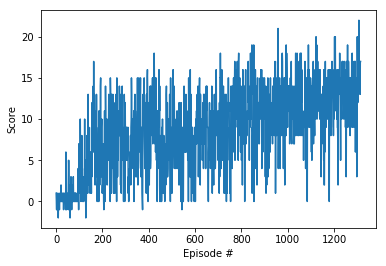

<Figure size 432x288 with 0 Axes>

In [13]:
# computing device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# environment
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
action_size = env.brains[brain_name].vector_action_space_size
state_size = env_info.vector_observations.size

# agent
seed = 0
agent = Agent(device, state_size, action_size, seed, buffer_size=int(1e5),priority_eps=1e-3,
                 replay_alpha= 0.7, batch_size=64, gamma=0.99, update_every=4, tau=1e-3, 
                 lr=5e-4,optim_step_size=500, optim_gamma=0.8, is_train=True, net_noise=0.01)

# DDQN with prioritized experience replay
scores = dqn(env, agent, train_mode=True, n_episodes=3500, max_t=2000, #eps_start=1.,eps_end=0.02,eps_decay=0.995,
        beta_reverse=0.5, beta_reverse_decay=0.9995)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
plt.savefig('images/noisy_net_score.png')

In [ ]:
env.close()